# Data Analysis and Fitting
# Errors and Goodness of Fit
Below we will explore how fitted parameter errors, chi-squared, and measurement errors are related. To keep things simple, we will use a linear forward model and linear data.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
font = {'size'   : 18}
matplotlib.rc('font', **font)
# set the random seed; get the same results each time we run this notebook
seed = sum([ord(x) for x in 'isrschool'])
np.random.seed(seed)
m_true = 3.5
b_true = -2

### Forward Model and Measured Data
Here we are working with a simple linear model:
$y = mx+b$

For this example, we'll define the true values for the parameters to be:
* m = 3.5
* b = -2

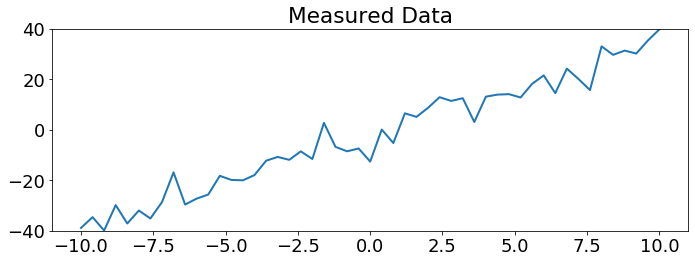

In [2]:
def model(x,m,b):
    return m*x + b

x = np.linspace(-10,10,num=51)
error = 4*np.random.randn(x.size)
data = model(x,m=m_true,b=b_true) + error

fig = pyplot.figure(figsize=(10,4))
ax = fig.add_subplot(111)
l = ax.plot(x,data,lw=2)
ax.set_title('Measured Data')
lim = ax.set_ylim([-40,40])
fig.tight_layout()

## Chi-Squared, Fitted Parameter Covariance, and Fitting Errors

For a linear forward model, we know that the least-squares solution in general is given by:

$\hat{\mathbf{p}}_{LS} = \left[H^T\mathbf{\Sigma}_e^{-1}H\right]^{-1}H^T \mathbf{\Sigma}_e^{-1} \mathbf{z}$

The chi-squared can be calculated with:

$ \chi^2 = \left(\mathbf{z} - H\mathbf{p}\right)^T\mathbf{\Sigma}_e^{-1}\left(\mathbf{z} - H\mathbf{p}\right)$

and the covariance of the fitted parameters is:

$\mathbf{\Sigma}_{\hat{\mathbf{p}}_{\rm LS}} = \left[H^T \mathbf{\Sigma}_{e}^{-1} H\right]^{-1}$


For 2-dimensional data, matrix $H$ has shape $[M \times 2]$ and $\mathbf{p}$ has shape $[2 \times 1]$:

$ H = \begin{pmatrix}
x_1 & 1 \\
x_2 & 1 \\
\vdots & \vdots \\
x_m & 1 \\
\end{pmatrix}
\quad \quad
\mathbf{p} = \begin{pmatrix}
m \\
b \\
\end{pmatrix}
$

If measurement errors are independent, $\mathbf{\Sigma}_e$ is diagonal, then, equivalently, the chi-squared can be written as:

$ \chi^2 = \sum^M_{m=1}{\frac{\left(z_m-(mx_m + b)\right)^2}{\sigma_m^2}} $

and the covariance of $\hat{\mathbf{p}}_{\rm LS}$ as:

$\mathbf{\Sigma}_{\hat{\mathbf{p}}_{\rm LS}} = \begin{pmatrix}
\sum^M_{m=1}{\frac{x_m^2}{\sigma_m^2}} & \sum^M_{m=1}{\frac{x_m}{\sigma_m^2}} \\
\sum^M_{m=1}{\frac{x_m}{\sigma_m^2}} & \sum^M_{m=1}{\frac{1}{\sigma_m^2}} \\
\end{pmatrix}^{-1}
$


For simplicity, let's assume that $\sigma_m = \sigma$ (known as homoscedasticity, whereas differing $\sigma_m$ is known as heteroscedasticity). Now let's look at how the chi-squared behaves for different measurement errors. We'll just change $\sigma$ and compare the resulting $ \chi^2 $. And let's only look at the $ \chi^2 $ in the "slope" dimension:

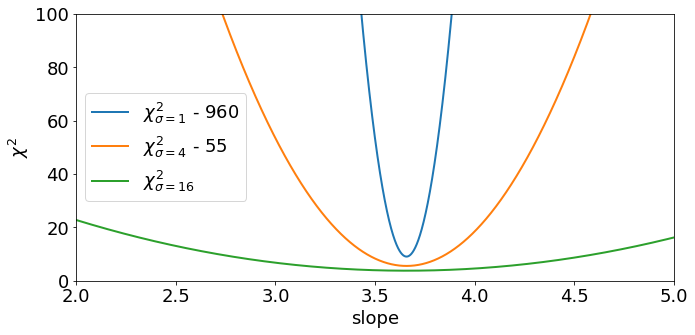

In [3]:
# calculate chi squared with different sigmas and plot
# for simplicity, we'll fit for both m and b, but we'll only look at chi-squared vs. m at the best fit b.
def get_reduced_chis(sigma):
    ms = np.linspace(2,5,num=5001)
    bs = np.linspace(-4,0,num=101)
    num_data = data.size
    chis = np.zeros((ms.size,bs.size))
    for i,m in enumerate(ms):
        diff = np.array([(data - model(x,m=m,b=b))/sigma for b in bs])
        chis[i,:] = np.sum(diff**2,axis=1)
            
    min_chi = np.min(chis)
    ind1,ind2 = np.where(chis == min_chi)
    chis = chis[:,ind2[0]]

    return ms, chis

ms, chis1 = get_reduced_chis(1)
_, chis4 = get_reduced_chis(4)
_, chis16 = get_reduced_chis(16)


# now plot
fig = pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(111)
tmp = ax.plot(ms,chis1-960,lw=2,label='$\chi^2_{\sigma=1}$ - 960')
tmp = ax.plot(ms,chis4-55,lw=2,label='$\chi^2_{\sigma=4}$ - 55')
tmp = ax.plot(ms,chis16,lw=2,label='$\chi^2_{\sigma=16}$')
tmp = ax.set_xlabel('slope')
tmp = ax.set_ylabel('$\chi^2$')
tmp = ax.set_xlim([2,5])
tmp = ax.set_ylim([0,100])
tmp = ax.legend()
fig.tight_layout()

As we can see in the plot, the larger the measurement errors, the "flatter" the chi-squared curve. This is because the covariance of the best-fit parameters is related to the chi-squared. The statistical significance of the fit is related to the chi-squared.

### Confidence from Chi-Squared Boundaries
We can construct a confidence interval by stepping up from the minimum $\chi ^2$ value by a $\Delta \chi ^2$. The confidence interval contains all values of the fitted parameters bounded by the $\chi ^2 +\Delta \chi ^2$.

For example, a "one sigma" (68%) significance confidence interval corresponds to $\Delta \chi ^2 = 1$. In the above plot, for $\sigma = 4$, the confidence interval for the slope is:

In [4]:
# get the minimum chi-squared
min_chi4 = np.min(chis4)
# best fit slope at minimum chi-squared
best_m = ms[chis4 == min_chi4]
# construct a 1 sigma confidence interval
delta_chi = 1
temp = sorted(ms[chis4 < (min_chi4 + delta_chi)])
confidence_interval = [temp[0],temp[-1]]
variance_from_chi = ((confidence_interval[1] - confidence_interval[0])/2)**2 / delta_chi

print('Best fit slope: %0.2f\nTrue slope: %0.2f' % (best_m, m_true))
print('68%% confidence interval for slope: [%0.2f, %0.2f]' % (confidence_interval[0], confidence_interval[1]))
print('Variance from chi-squared: %0.5f' % variance_from_chi)

Best fit slope: 3.66
True slope: 3.50
68% confidence interval for slope: [3.56, 3.75]
Variance from chi-squared: 0.00899


### Confidence from Covariance Matrix of the Fitted Parameters

In comparison, the variance for the slope can be calculated with:

$\sigma_{slope}^2 = \left(\sum^M_{m=1}{\frac{1}{\sigma_m^2}}\right)/\left(\sum^M_{m=1}{\frac{x_m^2}{\sigma_m^2}}\sum^M_{m=1}{\frac{1}{\sigma_m^2}} - \left(\sum^M_{m=1}{\frac{x_m}{\sigma_m^2}}\right)^2\right)$

(this formula corresponds to the first element of $\mathbf{\Sigma}_{\hat{\mathbf{p}}_{\rm LS}}$)

In [5]:
sigma = 4
variance = (data.size/(sigma**2))/(np.sum(x**2/(sigma**2))*data.size/(sigma**2) - (np.sum(x/(sigma**2)))**2)
print('Variance from covariance matrix formula: %0.5f' % variance)

Variance from covariance matrix formula: 0.00905


## Goodness of Fit

So now we can determine the errors in the fitted parameters, but how do we know if the fit is meaningful? Perhaps the model is unable to accurately reproduce the data? Or perhaps the model is able to reproduce the data more accurately than one would expect given random measurement errors?

The standard goodness of fit test involves computing the "reduced chi-squared":

$\chi^2_\nu = \chi^2/(m-n+1)$

Then, typically:

$\chi^2_\nu \approx 1 $: signals a good fit

$\chi^2_\nu << 1 $: signals an "over fit"

$\chi^2_\nu >> 1 $: signals a poor fit

The $\chi^2_\nu$ could also be slightly larger or smaller than 1 depending on how accurately one is able to estimate the input measurement errors.

So what is the reduced chi-squared for the different measurement errors we used above?

In [6]:
# get the reduced chi-squared for each measurment error we used (1, 4, and 16)
min_chi1 = np.min(chis1)/(data.size - 2 + 1)
min_chi4 = np.min(chis4)/(data.size - 2 + 1)
min_chi16 = np.min(chis16)/(data.size - 2 + 1)

print('For measurement errors sigma=1, reduced chi-squared = %0.3f' % min_chi1)
print('For measurement errors sigma=4, reduced chi-squared = %0.3f' % min_chi4)
print('For measurement errors sigma=16, reduced chi-squared = %0.3f' % min_chi16)

For measurement errors sigma=1, reduced chi-squared = 19.381
For measurement errors sigma=4, reduced chi-squared = 1.211
For measurement errors sigma=16, reduced chi-squared = 0.076


As expected, the reduced chi-squared for measurement errors $\sigma=4$ is closest to 1! This is because we added $\sigma=4$ random normal error to the fake measurement data produced at the beginning of this notebook.